In [546]:
import pandas as pd 
import numpy as np 
import rasterio
from matplotlib import pyplot as plt
import math
import time
import io
import numpy as np
import csv
from IPython.display import Image, display

import os
import shutil
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from  torchvision.transforms import ToTensor, Compose, Normalize, Resize, v2
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

## Visualize the data to be combined

TMEAN

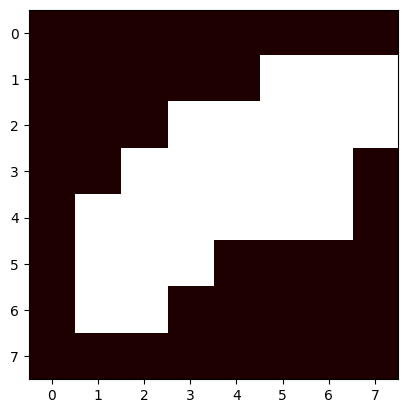

In [547]:
img = rasterio.open('./Q2_2022/TMEAN_DATA_Clipped_Q2_2022 _copy/train/PRISM_tmean_stable_4kmD2_20220401_bil.tif')
full_img = img.read(1)
plt.imshow(full_img, cmap='pink')

PPT

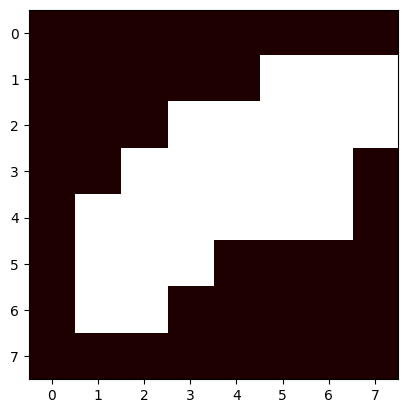

In [548]:
img = rasterio.open('./Q2_2022/PPT_DATA_Clipped_Q2_2022_copy/train/PRISM_ppt_stable_4kmD2_20220401_bil.tif')
full_img = img.read(1)
plt.imshow(full_img, cmap='pink')

DEMs (should be stacked already)

In [549]:
# file_list = ['DIR.tif','NLCD.tif']
# path = '../Data/03539600/03539600_Context_Tif/'
# for layer in file_list:
#     # print(path + layer)
#     img = rasterio.open(f'../Data/03539600/03539600_Context_Tif/{layer}')
#     full_img = img.read(1)
#     plt.imshow(full_img, cmap='gray')
#     plt.title({layer})
#     plt.show()

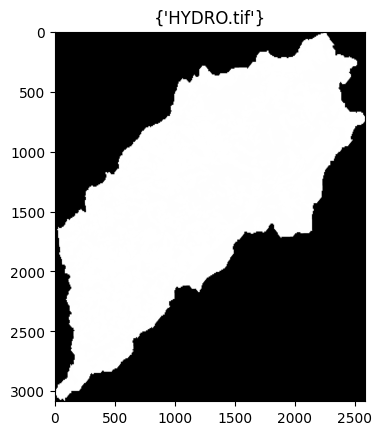

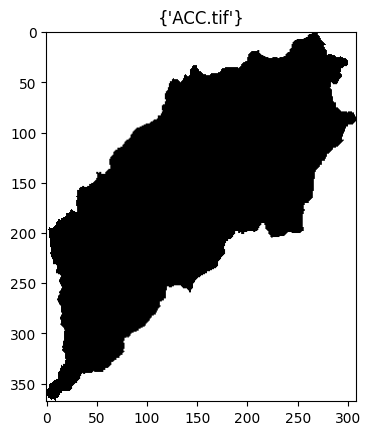

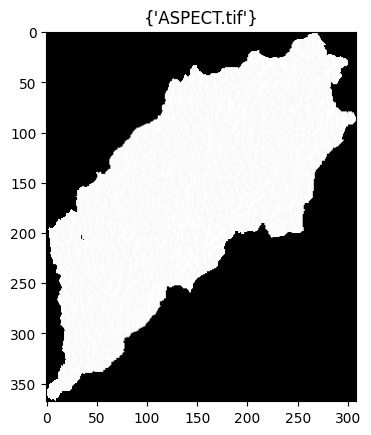

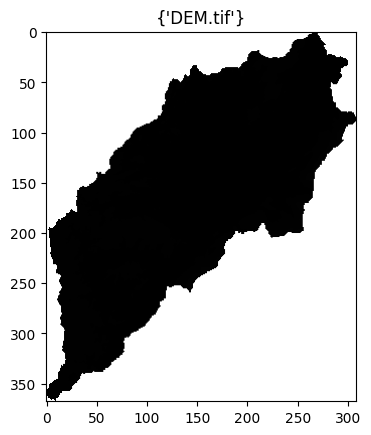

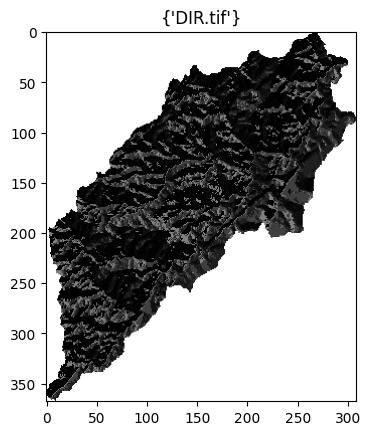

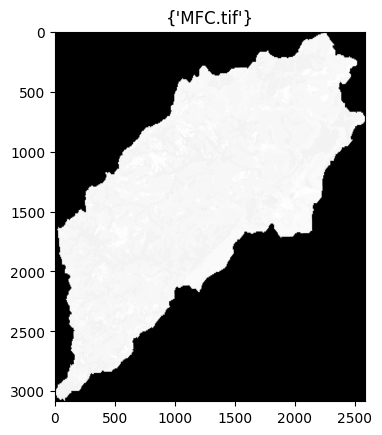

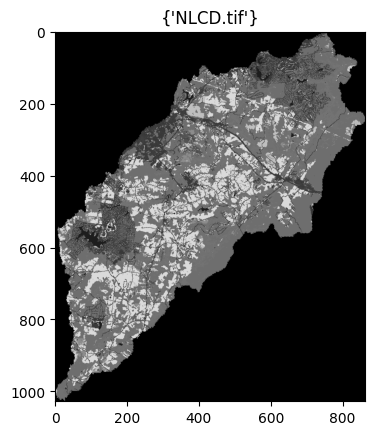

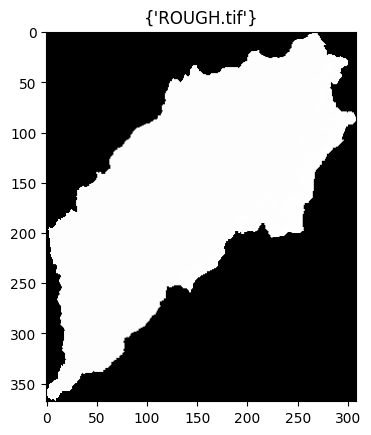

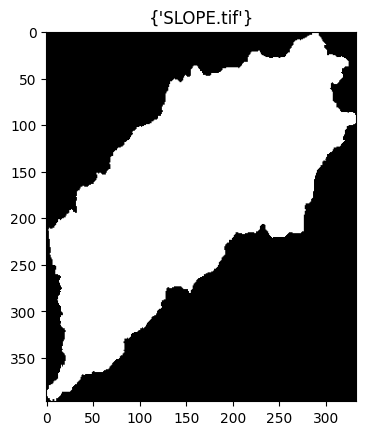

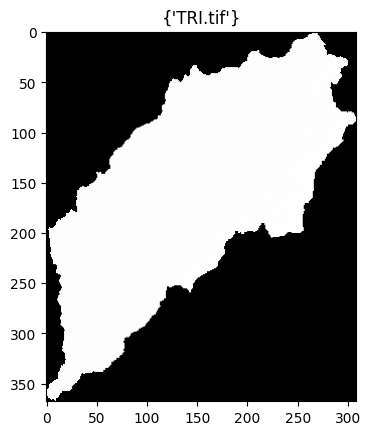

In [550]:
file_list = ['HYDRO.tif','ACC.tif', 'ASPECT.tif', 'DEM.tif','DIR.tif','MFC.tif','NLCD.tif','ROUGH.tif','SLOPE.tif','TRI.tif']
# file_list = ['DIR.tif','NLCD.tif']
path = '../Data/03539600/03539600_Context_Tif/'
for layer in file_list:
    # print(path + layer)
    img = rasterio.open(f'../Data/03539600/03539600_Context_Tif/{layer}')
    full_img = img.read(1)
    plt.imshow(full_img, cmap='gray')
    plt.title({layer})
    plt.show()

Now we stack these 3 together

In [551]:
im3 = './Q2_2022/TMEAN_DATA_Clipped_Q2_2022 _copy/train/PRISM_tmean_stable_4kmD2_20220401_bil.tif'
im2 ='./Q2_2022/PPT_DATA_Clipped_Q2_2022_copy/train/PRISM_ppt_stable_4kmD2_20220401_bil.tif'
im1 = "./Q2_2022/DEMs/Train/03539600_DEM.tif1.tif"

file_list = []
file_list.extend([im1,im2,im3])
file_list

['./Q2_2022/DEMs/Train/03539600_DEM.tif1.tif',
 './Q2_2022/PPT_DATA_Clipped_Q2_2022_copy/train/PRISM_ppt_stable_4kmD2_20220401_bil.tif',
 './Q2_2022/TMEAN_DATA_Clipped_Q2_2022 _copy/train/PRISM_tmean_stable_4kmD2_20220401_bil.tif']

In [552]:
with rasterio.open("../Data/03539600/03539600_Context_Tif/HYDRO.tif") as src0:
    meta = src0.meta
    meta["dtype"] = "float32"

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

with rasterio.open('03539600_ALL.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

In [553]:
print(dst.count)
print(dst.shape)
print(dst.dtypes)
print(dst.crs)

3
(3084, 2589)
('float32', 'float32', 'float32')
LOCAL_CS["NAD83(2011) / Tennessee",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Make sure we got this right

In [ ]:
with rasterio.open("./03539600_ALL.tif") as image:
    fig, axes = plt.subplots(ncols=len(file_list))
    fig.set_size_inches(20, 10)

    for i, col in enumerate(axes):
        col.imshow(image.read(i+1), cmap='pink')

    plt.show()

Now we have to loop through all images in DEM/PPT/TMEAN folders
 
(train/validation/test split will occur after combination)

In [ ]:
tlist = os.listdir("./Q2_2022/TMEAN_DATA_Clipped_Q2_2022 _copy/all_tmean")
plist = os.listdir("./Q2_2022/PPT_DATA_Clipped_Q2_2022_copy/all_ppt/")
dlist = os.listdir("./Q2_2022/DEMs/all_dems/")

In [ ]:
tpath = "./Q2_2022/TMEAN_DATA_Clipped_Q2_2022 _copy/all_tmean/"
ppath = "./Q2_2022/PPT_DATA_Clipped_Q2_2022_copy/all_ppt/"
dpath = "./Q2_2022/DEMs/all_dems/"

dst_list = []
for i in range(len(dlist)):
    file_list = []
    # for j in plist:
    #     for k in dlist:
    im1 = tpath + tlist[i]
    im2 = ppath + plist[i]
    im3 = dpath + dlist[i]
    file_list.extend([im3,im2,im1])

    with rasterio.open(dpath + dlist[i]) as src0:
        meta = src0.meta
        meta["dtype"] = "float32"

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    with rasterio.open('./Q2_2022/STACK/'+f'{i+1}_03539600_ALL.tif', 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))
    dst_list.append(dst)


file_list[-1]


In [ ]:
with rasterio.open("./Q2_2022/STACK/1_03539600_ALL.tif") as image:
    fig, axes = plt.subplots(ncols=len(file_list))
    fig.set_size_inches(20, 10)

    for i, col in enumerate(axes):
        col.imshow(image.read(i+1), cmap='pink')

    plt.show()

## Prepare the target Data

In [ ]:
files_in_directory = all_files = [file for file in os.listdir("./Q2_2022/STACK/") if file.endswith(".tif")]
files_in_directory.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

files_in_directory = pd.DataFrame(files_in_directory, columns=["File Name"])
print(files_in_directory,"\n", len(files_in_directory), "\n", type(files_in_directory))

In [ ]:
target = pd.read_excel("../Data/03539600/03539600_Q2_2022.xlsx")
target.drop(columns=["agency_cd",  "site_no","datetime"], inplace=True)
target.rename(columns={"Discharge, cubic feet per second (Mean)": "Discharge (Mean)"}, inplace=True)
print(target[:5],"\n", len(target), "\n", type(files_in_directory))

In [ ]:
imgcsv = pd.concat([files_in_directory, target],axis=1)
imgcsv[0:5]
imgcsv.to_csv("./Q2_2022/target/Q2_2022_target_full.csv")

In [ ]:
df = pd.read_csv("./Q2_2022/target/Q2_2022_target_full.csv")
df.drop("Unnamed: 0", inplace=True, axis=1)
print(df[:5],"\n", len(df), "\n", type(df))
train = df[:56]
valid = df[56:74]
test = df[74:]
print(len(train),len(valid),len(test))
train.to_csv("./Q2_2022/target/Q2_2022_target_train.csv")
valid.to_csv("./Q2_2022/target/Q2_2022_target_valid.csv")
test.to_csv("./Q2_2022/target/Q2_2022_target_test.csv")

Congrats you made the input image directory!

Now lets split it into train test and validation sets

In [ ]:
og_folder = "./Q2_2022/STACK/"
train_folder = "./Q2_2022/STACK/train/"
validation_folder = "./Q2_2022/STACK/validation/"
test_folder = "./Q2_2022/STACK/test/"

all_files = [file for file in os.listdir("./Q2_2022/STACK/") if file.endswith(".tif")]

# important to maintain proper sequence order
all_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
# all_files

In [ ]:
for file in all_files[:56]:
    src = og_folder + file
    dest = train_folder + file
    shutil.copy(src,dest)

for file in all_files[56:74]:
    src = og_folder + file
    dest = validation_folder + file
    shutil.copy(src,dest)

for file in all_files[74:]:
    src = og_folder + file
    dest = test_folder + file
    shutil.copy(src,dest)

In [ ]:
for file in all_files:
    os.remove(os.path.join(og_folder,file))

Now the data is prepared to be used by the data loader

Next step is to process data through an autoencoder. First we define our Custom Pytorch Dataset Class and create our Pytorch input datasets

In [ ]:
class GeoContextData(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['File Name']
        self.y = torch.tensor(df['Discharge (Mean)'].values).unsqueeze(-1)
        img_count = len(self.img_names)
        self.all_data = torch.empty((img_count,3,224,224))

        self.transform = transform

        # Load data into memory
        for i,n in enumerate(self.img_names):
            
            with rasterio.open(os.path.join(self.img_dir + n), 'r') as src:
                img = src.read() 
                img = ToTensor()(img)
                data = F.normalize(img, p = 2.0, dim = 0)
                # Pad data to create square images
                data = F.pad(data, (0,0,0,0,0,495))
                # get dimensions in right spots
                data = torch.permute(data, (1,2,0))
                # Limit highly negative values
                data = torch.clamp(data,min=-1,max=None)
                # reshape to resnet standard size
                data = v2.functional.resize(data, (224,224))
                # Add data to full tensor
                self.all_data[i] = data

        # get dimensions in right spots
        print(self.all_data.shape)
        # self.all_data = torch.permute(self.all_data, (1,2,0))
                


    def __getitem__(self, idx):
        
        # Get image
        data = self.all_data[idx]

        # Get flow rate
        discharge = self.y[idx]

        # Apply transforms
        if self.transform:
            data = self.transform(data)
        
        return data, discharge

    def __len__(self):
        return self.y.shape[0]

In [ ]:
transform = None

# Compose([
#                     # ToTensor(),
#                     # Resize((224,224)),
#                     # Normalize(0.5, 0.5)
#                      ])

In [ ]:
train_dataset = GeoContextData(csv_path='./Q2_2022/target/Q2_2022_target_train.csv',
                          img_dir='./Q2_2022/STACK/train/',
                          transform=transform)

In [ ]:
validation_dataset = GeoContextData(csv_path='./Q2_2022/target/Q2_2022_target_valid.csv',
                          img_dir='./Q2_2022/STACK/validation/',
                          transform=transform)

In [ ]:
test_dataset = GeoContextData(csv_path='./Q2_2022/target/Q2_2022_target_test.csv',
                          img_dir='./Q2_2022/STACK/test/',
                          transform=transform)

Create Loaders

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=5,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

valid_loader = DataLoader(dataset=validation_dataset,
                          batch_size=5,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=5,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0)

Check data contained in loaders

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
dataiter = iter(train_loader)
images,labels = next(dataiter)
images.to(device)
labels.to(device)
print(torch.min(images), torch.max(images))
print(torch.mean(images), torch.std(images))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

for batch_idx, (x, y) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)

In [ ]:
print(x.shape)

In [ ]:
# x_image_as_vector = x.view(-1, 224*224)
# print(x_image_as_vector.shape)

## Define some autencoders 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Can we improve with a CNN Autoencoder?

In [ ]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Linear()
        
        self.encoder = nn.Sequential(
            # nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(3, 64, 9, 1, 0), # input dim: (3, 224, 224); next dim: (64, 215, 215)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),

            # nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),

            # nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),
            
            # Final encoded image size (batch first): torch.Size([5, 128, 106, 106])
            

            
            # using a strided convultion to compress instead of maxpool as
            # maxpool doesn't work in nn.sequential (need to save
            # another output from it to feed to unpool in decoder).
        )

        self.decoder = nn.Sequential(
            nn.Upsample((128,128),  mode='nearest'),
            nn.Conv2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(True),

            nn.Upsample((64,64), mode='nearest'),
            nn.Conv2d(64, 64, 3, stride=1, padding=1), # 64, 358, 358
            nn.ReLU(True),
            
            nn.Upsample((224,224), mode='nearest'),
            nn.Conv2d(64, 3, 9, stride=1, padding=4),
            nn.Tanh(),
             
        )

    def forward(self,x):
        encoded = self.encoder(x).to(device)
        decoded = self.decoder(encoded).to(device)
        out = []
        out.append(encoded)
        out.append(decoded)
        return out

In [ ]:
# model = CNNAutoencoder().to(device)
model = CNNAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [540]:
num_epochs = 1
outputs=[]
# data_loader = train_loader
for epoch in range(num_epochs):
    for(img,_) in train_loader:
        # img = img.permute(0,3,2,1).to(device)
        img = img.to(device)
        
        
        out = model.forward(img)
        encode = out[0].to(device)
        recon = out[1].to(device)
        # print(img.size(), "\n", recon.size())
        loss = criterion(recon,img).to(device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item():4f}')
    outputs.append((epoch,img,recon,encode))

Epoch: 1, Loss: 0.000129


In [ ]:
for k in range(0, num_epochs, 6):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs[k][1].to('cpu').detach().numpy()
    recon = outputs[k][2].to('cpu').detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break 
        plt.subplot(2,9,i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break 
        plt.subplot(2,9,9+ i+1)
        plt.imshow(item[0])

In [545]:
print(outputs[0][3].shape)

torch.Size([5, 128, 106, 106])


In [ ]:
print(outputs[0][1].to('cpu').detach().numpy().min(), outputs[0][1].to('cpu').detach().numpy().max())

In [ ]:
print(outputs[0][2].to('cpu').detach().numpy().min() ,outputs[0][2].to('cpu').detach().numpy().max() )

In [ ]:
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # raw image dim: (3, 368, 309)
        # reshaped image dim: (3, 224, 224)
        # batch dim: (M, 3, 113712) (batch_first = True)
        self.encoder = nn.Sequential(
            nn.Linear(224*224, 500), # reduce the size from (M, 113712) to (M, 256)
            nn.ReLU(),
            nn.Linear(500, 256), 
            nn.ReLU(),
            nn.Linear(256, 64), 
            nn.ReLU(),
            nn.Linear(64, 12) # final output size is (M,12)
        )

        self.decoder = nn.Sequential(
            nn.Linear(12, 64), # input size is 12, output is 64
            nn.ReLU(),
            nn.Linear(64, 256), 
            nn.ReLU(),
            nn.Linear(256, 500), 
            nn.ReLU(),
            nn.Linear(500, 224*224), # final output size is (M,113712)
            nn.LeakyReLU() # choose Leaky ReLU as final activation since pixels range from tensor(-19999.) to tensor(34.7504) when normalized
        )


    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
model = LinearAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
num_epochs = 20
outputs=[]
# data_loader = train_loader
for epoch in range(num_epochs):
    for(img,_) in train_loader:
        img = img.reshape(-1, 224*224).to(device)
        recon = model(img).to(device)
        loss = criterion(recon,img)
        # print(type(loss))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item():4f}')
    outputs.append((epoch,img,recon))

In [ ]:
for k in range(0, num_epochs, 5):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs[k][1].to('cpu').detach().numpy()
    recon = outputs[k][2].to('cpu').detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break 
        plt.subplot(2,9,i+1)
        item = item.reshape(-1, 224, 224)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break 
        plt.subplot(2,9,9+ i+1)
        item = item.reshape(-1, 224, 224)
        plt.imshow(item[0])